## Robot programming workshop 06

<div class="alert alert-block alert-info">For this workshop you will be using a new robot, the dr20, and a new environment, a short 'maze' with a curvy path to get gent out. The dr20 robot had a richer array of sensors than the line-following robot, with <b>4 left and right facing ultrasonic sensors, a front facing laser sensor and a front facing camera</b>. The goal of this workshop is to interface with the robot class and write some code to pilot the robot out of the 'maze'.  At the moment there is no definite end to the 'maze' (emerging from the walled part) so you will have to see if there is any change to the sensors to see if there is a way of detecting this state.  Make sure you have save sim.py, simConst.py (or vrepConst.py) and remoteApi.dll files to a directory and also downloaded the short_path_vrep.ttt to your working folder (a known location)</div>

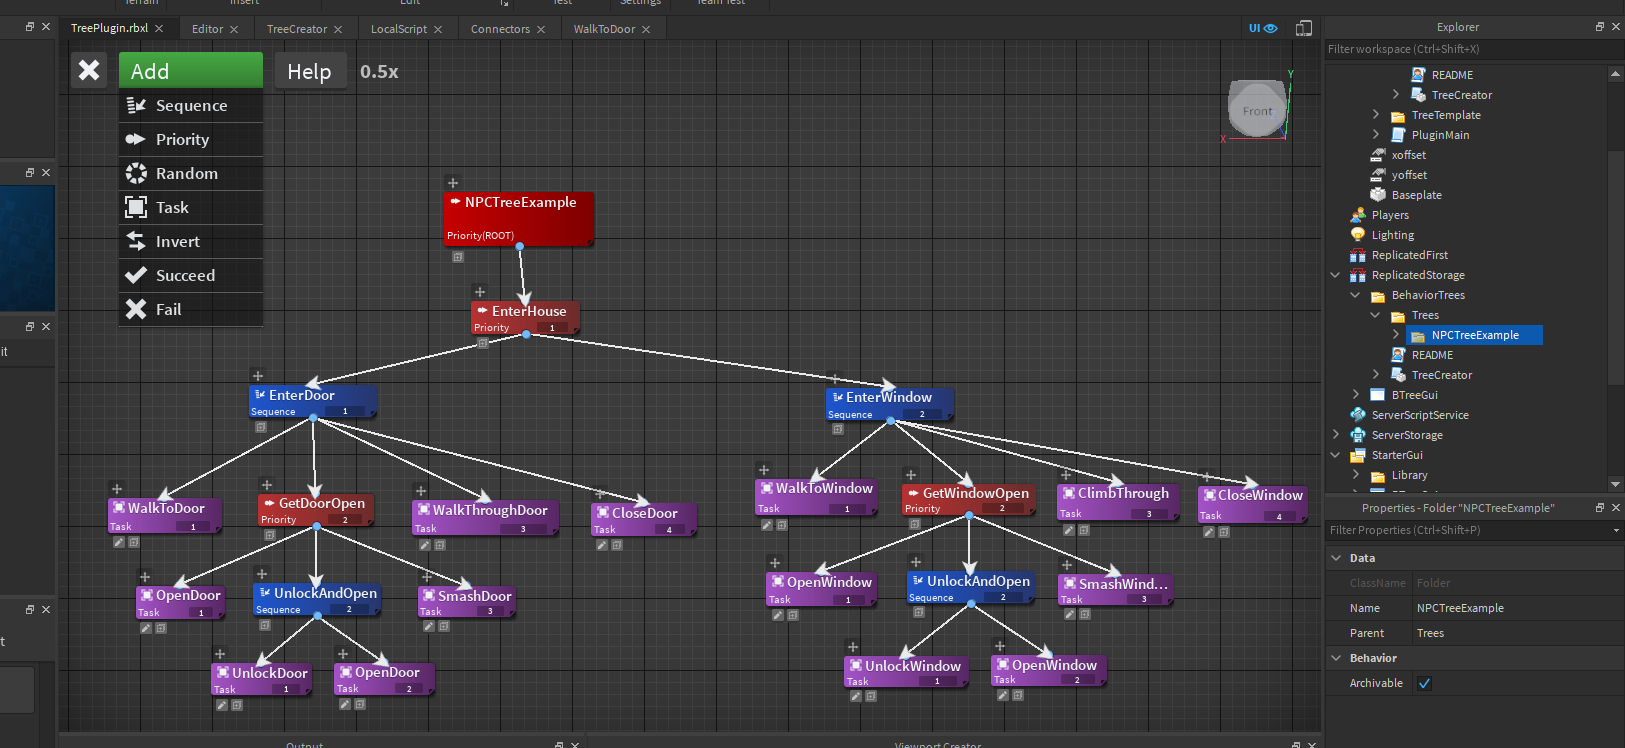

<font color="red"><b>Task 1:</b></font> Download the <b>short_path_vrep.ttt</b> to a working directory where you have saved sim.py, simConst.py (or vrepConst.py) and remoteApi.dll and change your path to that directory.  

In [1]:
import os
desiredPath = "C:/Users/2411375/OneDrive - University of Wolverhampton/Robotics/Files" # set path to working folderp" # set this path to your working folder
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check

try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import sys
import numpy as np  # used for the camera data

## choose the correct version of the library to import  
if os.path.isfile('/'.join([desiredPath, 'vrepConst.py'])):
    import vrepConst as wlvConst
else:
    import simConst as wlvConst

Current working directory: C:\Users\2411375\OneDrive - University of Wolverhampton\Robotics\Files


<font color="red"><b>Task 2:</b></font> Load the other libraries we are going to use for this workshop.  

In [2]:
from Dr20Robot import Dr20Robot_Interface
class Dr20Robot(Dr20Robot_Interface):

    def __init__(self, sim, clientID):
        Dr20Robot_Interface.__init__(self, sim, clientID)

    def behaviourTree(self):
        assert False, "Abstract, this method (behaviourTree) should be overridden" 

    def robotBehaviour(self):
        ##    print(unicode_tree(root))
        # Run the root until it returns true
        self.behaviour_tree.run()


### Behaviour tree engine

<font color="red"><b>Task 3:</b></font> These classes are the core components of the behaviour tree, they define the structures that the engine is built upon. <b>Note:</b> the interface between the behaviour tree and the Robot needs a scratch pad/buffer/database by which to pass values which is the purpose of the WhiteBoardStatus class.

In [3]:
class WhiteBoardStatus:
    def __init__(self, bot):
        self.robot  = bot    # So the BT can communicate with the robot
        self.onLine = False  # Open door?
        self.sensorReading = [None] * 5 # Left, Middle, Right
        self.behaviour = None
        self.startTime = 0
        
# Base class for a leaf of a Tree Behaviour
class Leaf:
    def __init__(self):
        pass

    def run(self):
        assert Flase, "Abstract, this method (run) should be overridden"

class Behaviour(Leaf):
    """
   Base class for a node of a Tree Behavior
    """
    def __init__(self):
        Leaf.__init__(self)
#        super(Leaf, self).__init__()
        self._children = []

    def run(self):
        pass

    def add_child(self, c):
        self._children.append(c)

    def add_children(self, cs):
        self._children.extend(cs)
        

class Status:
    FAILURE = 0
    SUCCESS = 1
    RUNNING = 2
    STOP    = 4
    
#def done(tree):
#    if tree.root.status == Status.SUCCESS:
#        raise Exception("done")

<font color="red"><b>Task 4:</b></font> The actual behaviour tree engine, this contains the classes for selectors, sequence, decorators, etc. Note: there are no concurrent/parallel variants for this implementation. 

In [4]:
import random

class Selector(Behaviour):
    """
    Implementation of the Selector
    """
    def __init__(self):
        Behaviour.__init__(self)
#        super(Selector, self).__init__()

    def run(self):
        for c in self._children:
            status = c.run()
            while status == Status.RUNNING:
                status = c.run()
            if status == Status.SUCCESS:
                return Status.SUCCESS
        return Staus.FAILURE


class Sequence(Behaviour):
    """
    Implementation of the Sequence
    """
    def __init__(self):
        Behaviour.__init__(self)
#        super(Sequence, self).__init__()

    def run(self):
        for c in self._children:
            status = c.run()
            while status == Status.RUNNING:
                status = c.run()
            if status == Status.FAILURE:
                return Status.FAILURE
        return Status.SUCCESS

class NDSelector(Selector):
    """
    Implementazione di un Selector
    """
    def __init__(self):
        Selector.__init__(self)

    def add_child(self, c):
        self._children.append(c)
        random.shuffle(self._children)


class NDSequence(Sequence):
    """
    Implementazione di un Sequence
    """
    def __init__(self):
        Sequence.__init__(self)

    def add_child(self, c):
        self._children.append(c)
        random.shuffle(self._children)

class Decorator(Leaf):
    # Implementation of the Decorator
    def __init__(self):
        Leaf.__init__(self)
        self._child = None

    def add_child(self, c):
        ## if isinstance(c, Leaf):
        self._child = c

    # This method should be overridden
    def run(self):
        return self._child.run()

<font color="red"><b>Task 5:</b></font> These are the specific behaviours for our robot working in a v-rep/coppiliasim <i>It is complete enough for this weeks workshop demonstration but may need to be edited, for example, to use the full set of sensors on the robot, to complete the workshop task</i>. 

In [5]:
class Stop(Behaviour):
    def __init__(self, status, consecutive_counts=10):
        super().__init__()
        self._status = status
        self._consecutive_counts = consecutive_counts
        self._count = 0

    def run(self):
        sensorReading = self._status.robot.readSensors()  
        sensorReading = self._status.sensorReading
        if sensorReading == [1.0, 1.0, 1.0, 1.0, 1.0]:
            self._count += 1
            if self._count == self._consecutive_counts:
                self._status.robot.stop()
                print("--Stop")
                return Status.SUCCESS
        else:
            self._count = 0
        return Status.RUNNING
    
class TurnLeft(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):      ## This simulates a blocking action
        status = Status.RUNNING
        #if self.sensorReading[]:
        if self._status.behaviour == None:
            print('--TurnLeft')
            self._status.robot.rotate_left(1.5)
            self._status.startTime=time.time()
            self._status.behaviour = "TurnLeft"
        elif self._status.behaviour == "TurnLeft" and time.time()-self._status.startTime > 2:
            self._status.robot.stop()
            self._status.behaviour = None
            status = Status.SUCCESS
        #else:
        return status

class TurnRight(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):      ## This simulates a blocking action
        status = Status.RUNNING
        if self._status.behaviour == None:
            print('--TurnRight')
            self._status.robot.rotate_right(1.5)
            self._status.startTime=time.time()
            self._status.behaviour = "TurnRight"
        elif self._status.behaviour == "TurnRight" and time.time()-self._status.startTime > 2:
            self._status.robot.stop()
            self._status.behaviour = None
            status = Status.SUCCESS
        return status

class GetClose(Behaviour):
    def __init__(self, status, child, distance=0.0, consecutive_counts=10):
        super().__init__()
        self._status = status
        self.add_child(child)
        self.distance = distance
        self._consecutive_counts = consecutive_counts
        self._count = 0

    def run(self):
        sensorReading = self._status.robot.readSensors()    
        self._status.sensorReading = sensorReading

        front = sensorReading[2]
        front_left = sensorReading[0]
        front_right = sensorReading[3]
        
        if sensorReading == [1.0, 1.0, 1.0, 1.0, 1.0]:
            self._count += 1
            if self._count == self._consecutive_counts:
                self._status.robot.stop()
                
                print("--Stop")
                sim.simxFinish(-1)
                status = Status.SUCCESS
        else:
            self._count = 0
            
        if front < 0.99:
            if front_left < 0.5 and front_left < front_right:
                print('TurnRight')
                self._status.robot.rotate_right(1.5)
                self._status.behaviour = "TurnRight"
                status = Status.RUNNING
            elif front_right < 0.5 and front_right < front_left:
                print('TurnLeft')
                self._status.robot.rotate_left(1.5)
                self._status.behaviour = "TurnLeft"
                status = Status.RUNNING
            else:
                status = Status.SUCCESS
        else:
            print('Forward')
            print(sensorReading)
            self._status.robot.move_forward(7)
            status = Status.RUNNING
            
        return status




class Forward(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        print('--Forward')
        status = Status.RUNNING
        self._status.robot.move_forward(2.0)
        status = Status.SUCCESS
        return status

class ReadSensors(Behaviour):
    def __init__(self, status):
        super().__init__()
        self._status = status

    def run(self):
        sensorReading = self._status.robot.readSensors()    
        self._status.sensorReading = sensorReading
        print("Sensor Readings:", sensorReading)
        status = Status.SUCCESS
        return status

# The following classes are decorators where we can specify custom behaviours
class TimeOut(Decorator):
    def __init__(self, child, duration=0):
        Decorator.__init__(self)
        self.add_child(child)
        self.delay = duration

    def run(self):
        status = self._child.run()
        if status == Status.SUCCESS:
            time.sleep(self.delay)
        return Status.SUCCESS

class DoTwice(Decorator):
    def __init__(self, child):
        Decorator.__init__(self)
        self.count = 0
        self.add_child(child)

    def run(self):
        if self.count < 2:
            self.count += 1
            self._child.run()
            return Status.RUNNING
        self.count = 0
        return Status.SUCCESS

    
class DoUntilClose(Decorator):
    def __init__(self, status, child, distance=0.0):
        Decorator.__init__(self)
        self._status = status
        self.add_child(child)
        self.distance = distance
        self.FixedDelay = 0.5

    def run(self):
        sensorReading = self._status.robot.readSensors()
        if sensorReading[2] < self.distance:
            return Status.SUCCESS
        self._child.run()
        time.sleep(self.FixedDelay)
        return Status.RUNNING


<font color="red"><b>Task 6:</b></font> Again I am using OO design here (inheritance and overriding) to expose the behaviourTree for modification. But it is this code than finally marries together the Robot control and the behaviour tree. <b>Note: the behaviour tree does nothing useful and you will have to implement your own to complete the workshop task</b>

In [6]:

class BTRobot(Dr20Robot):
    def __init__(self, sim, clientID):
        Dr20Robot.__init__(self, sim, clientID)
        self.behaviour_tree = self.behaviourTree()
        
    def behaviourTree(self):
        status = WhiteBoardStatus(self)

        turnRight = TurnRight(status)
        turnLeft = TurnLeft(status)
        forward = Forward(status)
        scan = ReadSensors(status)
        stop = Stop(status, consecutive_counts=10)
        sens = ReadSensors(status)
        getClose = GetClose(status, forward, 0.5)
        duration = TimeOut(scan, duration=0.5)

        start = NDSelector()
        root = Sequence()

        start.add_children([forward])
        root.add_children([start, getClose])

        return root


<font color="red"><b>Task 7:</b></font> Implements our interface to v-rep/Coppeliasim and creates the behaviour tree robot ready for running in the simulator. 

In [7]:
def shortPathMain(viewSensors=False, iterations = 40):
    print ('Program started')
    sim.simxFinish(-1) # just in case, close all opened connections

    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

    if clientID != -1:
        print ('Connected to remote API server')
    else:
        print('Connection failed!!')
        sys.exit('Could not connect')

    ## Create the robot object
    bot = BTRobot(sim, clientID)
    bot.viewSensors = viewSensors  # yeah - setters are for Java jockeys!!

    ## Run the robot loop
    for _ in range(iterations):
        bot.robotBehaviour()
        time.sleep(1.0)

    ## Stop the robot
    bot.stop()
    time.sleep(0.5)    ## delay to execute the command
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...done")

Remember to <b>run the v-rep/CoppeliaSim scene first</b> and then run the cell below.

In [ ]:
viewSensors = False ## I don't think I have this part working as yet!!!
try:
    shortPathMain(viewSensors)
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...uh oh, something went wrong!!!")

Program started
Connected to remote API server
--Forward
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[0.3298657273398944, 0.46643155611156323, 1.0, 1.0, 1.0]
Forward
[0.3298444563732609, 0.46657335210465656, 1.0, 1.0, 1.0]
Forward
[0.32983351572937053, 0.4666876629393742, 1.0, 1.0, 1.0]
Forward
[0.3298342082038144, 0.46683980734172364, 1.0, 1.0, 1.0]
Forward
[0.32985831103535007, 0.4669623130581251, 1.0, 1.0, 1.0]
Forward
[0.3298966650169819, 0.4670112734238887, 1.0, 1.0, 1.0]
Forward
[0.3299384123825261, 0.4670600840698345, 1.0, 1.0, 1.0]
Forward
[0.3299760216618481, 0.4671084164418885, 1.0, 1.0, 1.0]
Forward
[0.33001434726506496, 0.46715893176048295, 1.0, 1.0, 1.0]
Forward
[0.3300517473704034, 0.4672063666404037, 1.0, 1.0, 1.0]
Forward
[0.33009007715913696, 0.46726166755183485, 1.0, 1.

Forward
[0.30517378570433407, 0.37974466206876506, 1.0, 1.0, 1.0]
Forward
[0.300919267345965, 0.3747269394991167, 1.0, 1.0, 1.0]
Forward
[0.2966581338507462, 0.36143266577721506, 1.0, 1.0, 1.0]
Forward
[0.2924041518310538, 0.3535964798694978, 1.0, 1.0, 1.0]
Forward
[0.28814574218455646, 0.3459315762845443, 1.0, 1.0, 1.0]
Forward
[0.2838880218979381, 0.3382553387782604, 1.0, 1.0, 1.0]
Forward
[0.2796319763815882, 0.33059031804797945, 1.0, 1.0, 1.0]
Forward
[0.27537206858059515, 0.32291610382241026, 0.9912161929106242, 1.0, 1.0]
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
Forward
[0.2603940469473982, 0.2855188956266809, 1.0, 1.0, 1.0]
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
Forward
[0.22775541049789247, 0.3273762679192767, 1.0, 1.0, 1.0]
TurnRight
Forward
[0.22197836224138945, 0.358055495348613, 1.0, 1.0, 1.0]
Forward
[0.22021379362887308, 0.37342593416870873, 1.0, 1.0, 1.0]
Forward
[0.21890008429910018, 0.39969443463381865, 1.0, 1.0, 1.0]
Forward
[0.22013050913

Forward
[0.5155483109366383, 0.6830939947196938, 1.0, 1.0, 1.0]
Forward
[0.5313167609619486, 0.676329217306448, 1.0, 1.0, 1.0]
Forward
[0.5470666809059369, 0.6695621396016197, 1.0, 1.0, 1.0]
Forward
[0.5628427927400894, 0.6627895672897315, 1.0, 1.0, 1.0]
Forward
[0.5651286209974976, 0.6560247356087645, 1.0, 1.0, 1.0]
Forward
[0.5591549186090066, 0.6492657500663207, 1.0, 1.0, 1.0]
Forward
[0.5531881017858993, 0.642491641056799, 1.0, 1.0, 1.0]
--Forward
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
Forward
[0.4522804157730769, 0.5460146487850162, 1.0, 1.0, 1.0]
Forward
[0.44911987686841687, 0.5535143980768374, 1.0, 1.0, 1.0]
Forward
[0.44581102440914, 0.5630792995363751, 1.0, 1.0, 1.0]
Forward
[0.44373020117984785, 0.5738838052260355, 1.0, 1.0, 1.0]
Forward
[0.4445734997210422, 0.5888560441959257, 1.0, 1.0, 1.0]
Forward
[0.4495295619273546, 0.6047523823357368, 1.0, 1.0, 1.0]
Forward
[0.4569142516961879, 0.6141333160122111, 1.0, 1.0, 1.0]
Forwar

Forward
[0.4916163677701998, 0.6194362089526425, 1.0, 1.0, 1.0]
Forward
[0.4990296749279074, 0.6103792660182914, 1.0, 1.0, 1.0]
Forward
[0.5064402682695657, 0.6013150964655116, 1.0, 1.0, 1.0]
Forward
[0.5138511387059805, 0.5922567984351867, 1.0, 1.0, 1.0]
--Forward
TurnRight
TurnRight
Forward
[0.4328814912372001, 0.46506781698064986, 1.0, 1.0, 1.0]
TurnRight
Forward
[0.42400207946739793, 0.4563782274042352, 1.0, 1.0, 1.0]
Forward
[0.4208458188414052, 0.45122380280438856, 1.0, 1.0, 1.0]
Forward
[0.41406402797535785, 0.4482837431048329, 1.0, 1.0, 1.0]
Forward
[0.40563139436115564, 0.44354528465227727, 1.0, 1.0, 1.0]
TurnRight
TurnRight
Forward
[0.3831523370533133, 0.41805498784382467, 1.0, 1.0, 1.0]
Forward
[0.37843345018626606, 0.4109741228912554, 1.0, 1.0, 1.0]
Forward
[0.37019011261256246, 0.4051658587781328, 1.0, 1.0, 1.0]
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
TurnRight
Forward
[0.31131246101215365, 0.38988624256981363, 1.

Forward
[0.6373055889148155, 1.0, 1.0, 0.6152925266972885, 0.40722084689889]
Forward
[0.6350032150729894, 1.0, 1.0, 0.6185186953205041, 0.4095231282205875]
Forward
[0.6327078872472, 1.0, 1.0, 0.6217595242227818, 0.41181880900903167]
Forward
[0.6304182088417047, 1.0, 1.0, 0.624974459866811, 0.4141085307385839]
Forward
[0.6281259002191218, 1.0, 1.0, 0.6281895755915378, 0.4164008452411905]
Forward
[0.6258278882557327, 0.7981001093083869, 1.0, 0.6314213745597343, 0.418698982770153]
Forward
[0.6235302805972955, 0.7952864301573759, 1.0, 0.6346249968224147, 0.42099638339925205]
Forward
[0.62123426936878, 0.792463423626372, 1.0, 0.6378378353992062, 0.4232922536649186]
Forward
[0.6189324093754305, 0.7896389132836338, 1.0, 0.6410524589603354, 0.42559384304183834]
Forward
[0.6166437015121291, 0.786800241407828, 1.0, 0.6442828906538454, 0.4278828775471815]
Forward
[0.6143434134004294, 0.783975789734671, 1.0, 0.6474972141333531, 0.43018293812921127]
Forward
[0.6120494701507665, 0.7811244852664854, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 1.0, 1.0, 1.0, 1.0]
Forward
[1.0, 

<font color="red"><b>Task 8:</b></font> As you can see the robot behaviour is random aand rubbish. So, can you devise and code a behaviour tree strategy that will allow the robot to progress through the 'maze'. Your strategy should favour moving forward if there is no obstacle in front of the robot or turning towards a space with the greatest distance if the robot is surrounded by walls. <i>Hint: 1) Examination of the sensor reading values may allow you a good idea of what the robot sees.</i> 

In [ ]:
class BTRobot(Dr20Robot):
    def __init__(self, sim, clientID):
        Dr20Robot.__init__(self, sim, clientID)
        self.behaviour_tree = self.behaviourTree()
        
    def behaviourTree(self):
        ## Add and edit your robot behaviour code here

In [ ]:
viewSensors = False ## I don't think I have this part working as yet!!!!
try:
    shortPathMain(viewSensors)
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...uh oh, something went wrong!!!")

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: we will look at adding even more intelligent behaviour to our robot design. </div>